In [1]:
import torch 
from torch import nn

import torchvision 
from torchvision import transforms , datasets , models
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt


In [2]:
train_data = datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.FashionMNIST("./data", train=False, transform=transforms.ToTensor())

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]

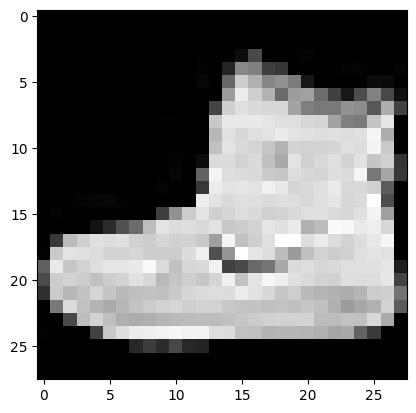

In [5]:
plt.imshow(image.permute(1,2,0), "gray")

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

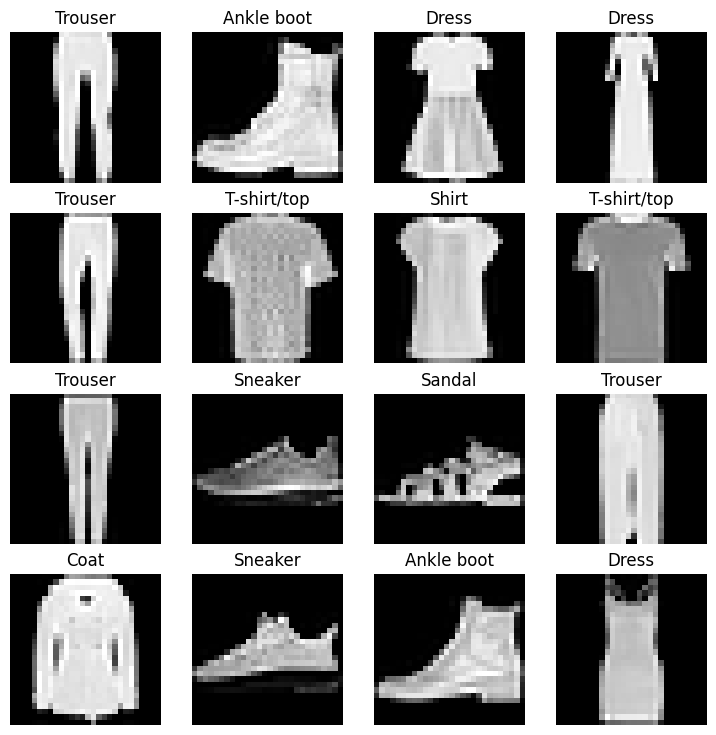

In [7]:
cols, rows = 4,4
fig = plt.figure(figsize=(9, 9))
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1,2,0), "gray")
    plt.title(class_names[label])
    plt.axis(False)

In [8]:
train_loader = DataLoader(train_data, 32, True)
test_loader = DataLoader(test_data, 32, True)

In [9]:
print(len(train_loader), len(test_loader))

1875 313


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
class MNISTModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 10),
            nn.Linear(10, 10)
        )
    def forward(self, X):
        return self.l1(X)

In [12]:
model_0 = MNISTModelV0().to(device)
model_0

MNISTModelV0(
  (l1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [13]:
next(model_0.parameters())

Parameter containing:
tensor([[ 0.0239, -0.0108,  0.0125,  ...,  0.0149, -0.0004,  0.0253],
        [-0.0347, -0.0146, -0.0305,  ...,  0.0272,  0.0227,  0.0115],
        [-0.0258,  0.0271, -0.0145,  ..., -0.0168, -0.0307,  0.0276],
        ...,
        [-0.0072,  0.0251,  0.0179,  ..., -0.0306,  0.0242,  0.0348],
        [ 0.0066,  0.0275, -0.0157,  ..., -0.0321,  0.0289, -0.0048],
        [ 0.0044, -0.0044, -0.0240,  ..., -0.0264,  0.0262,  0.0256]],
       device='cuda:0', requires_grad=True)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [15]:
img, label = next(iter(test_loader))
img, label = img.to(device), label.to(device)
img.shape, label.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [16]:
img.device

device(type='cuda', index=0)

In [17]:
model_0.eval()
with torch.inference_mode():
    pretrain_pred = torch.softmax(model_0(img), dim=1)
    

torch.argmax(pretrain_pred,dim=1),label

(tensor([7, 9, 7, 9, 7, 7, 7, 6, 7, 7, 7, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 9, 7, 9, 9, 7], device='cuda:0'),
 tensor([0, 1, 9, 7, 0, 5, 0, 5, 0, 9, 8, 5, 7, 7, 7, 8, 9, 0, 8, 9, 4, 4, 0, 9,
         9, 6, 6, 4, 6, 1, 1, 4], device='cuda:0'))

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
from tqdm.auto import tqdm

In [20]:
torch.manual_seed(42)

epochs = 3

for epoch in tqdm(range(epochs)):
    
    print(f'Epoch: {epoch} |......')

    for batch,(images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        model_0.train()
        logits = model_0(images)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 400 == 0:
            print(f"Looked at {batch * len(images)}/{len(train_loader.dataset)} samples.")
        
        model_0.eval()

    with torch.inference_mode():
        for images_, labels_ in test_loader:
            images_, labels_ = images_.to(device), labels_.to(device)

            test_logits = model_0(images_)
            test_pred = torch.argmax(test_logits, dim=1)
            test_loss = criterion(test_logits, labels_)
      



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 |......
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Epoch: 1 |......
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Epoch: 2 |......
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


In [21]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
# train_time_start_on_cpu = timer() 

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  ### Training
  # train_loss = 0
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)

    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)
    
    # 2. Calculate loss (per batch)
    loss = criterion(y_pred, y)
    # train_loss += loss # accumulate train loss
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step (update the model's parameters once *per batch*)
    optimizer.step()
    
    # Print out what's happening
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_loader.dataset)} samples.")
  
  # Divide total train loss by length of train dataloader
  # train_loss /= len(train_loader)

  ### Testing
  # test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode(): 
    for X_test, y_test in test_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate loss (accumulatively)
      # test_loss += criterion(test_pred, y_test)

      # 3. Calculate accuracy
      # test_acc += accuracy_score(y_true=y_test.cpu().detach(), y_pred=test_pred.argmax(dim=1).cpu().detach())

    # Calculate the test loss average per batch
    # test_loss /= len(test_loader)

    # Calculate the test acc average per batch
    # test_acc /= len(test_loader)

  # Print out what's happening
  # print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training tim

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


In [22]:
torch.mean(torch.tensor(acc_mat)).item()

NameError: name 'acc_mat' is not defined

In [23]:
208.35/60

3.4724999999999997

In [24]:
class MNISTModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10),
            # nn.ReLU(),
            nn.Linear(10, 10),
            # nn.ReLU(),
            # nn.Softmax(dim=1)
        )
    def forward(self, X):
        return self.l1(X)

In [25]:
model_1 = MNISTModelV0().to(device)
model_1

MNISTModelV0(
  (l1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [27]:
def Train_model(
        model:torch.nn.Module,
        data_loader:torch.utils.data.DataLoader,
        loss_fn,
        optimizer,
        acc_fn,
        device:torch.device=device):
    # put model to Train
    model.train()

    #iniate loss and acc sum var
    train_loss, train_acc= 0, 0

    #start looping on epochs
    
        
        #looping over Data_Loader
    for X, y in data_loader:

        #put data into processing device 
        X, y = X.to(device), y.to(device)

        #Get Model predictions
        pred = model(X)
        
        #compute the current Loss and Acc
        loss = loss_fn(pred, y)
        train_loss+=loss
        # print(acc_fn(pred.argmax(dim=1).cpu().detach(), y.cpu().detach()))
        train_acc += acc_fn(pred.argmax(dim=1).cpu().detach(), y.cpu().detach())

        #Reset optimizer to Zero
        optimizer.zero_grad()

        #Compute the Gradient
        loss.backward()
        
        # Back Propagate step
        optimizer.step()
    train_loss /=len(data_loader)
    train_acc  /=len(data_loader)

    return f"Train_Loss: {train_loss} | Train_Acc: {train_acc}"

def Test_model(
        model:torch.nn.Module,
        data_loader:torch.utils.data.DataLoader,
        loss_fn,
        acc_fn,
        device:torch.device=device):
    # put model to Train
    model.eval()

    #iniate loss and acc sum var
    test_loss, test_acc= 0, 0

    #start looping on epochs
    
        
        #looping over Data_Loader
    for X, y in data_loader:

        #put data into processing device 
        X, y = X.to(device), y.to(device)

        #Get Model predictions
        pred = model(X)
        
        #compute the current Loss and Acc
        loss = loss_fn(pred, y)
        test_loss+=loss
        # print(acc_fn(pred.argmax(dim=1).cpu().detach(), y.cpu().detach()))
        test_acc += acc_fn(pred.argmax(dim=1).cpu().detach(), y.cpu().detach())

    test_loss /=len(data_loader)
    test_acc  /=len(data_loader)

    return f"Test_Loss: {test_loss} | Test_Acc: {test_acc}"

In [28]:
epochs=3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}......")
    print(Train_model(model_1, train_loader, criterion, optimizer, accuracy_score, device))
    print(Test_model(model_1, test_loader, criterion, accuracy_score, device))

print("#"*30,"\n")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0......
Train_Loss: 0.591284990310669 | Train_Acc: 0.7896666666666666
Test_Loss: 0.5057187080383301 | Test_Acc: 0.8191892971246006
Epoch: 1......
Train_Loss: 0.4762963056564331 | Train_Acc: 0.8325
Test_Loss: 0.47573354840278625 | Test_Acc: 0.8314696485623003
Epoch: 2......
Train_Loss: 0.454604834318161 | Train_Acc: 0.8398833333333333
Test_Loss: 0.4800040125846863 | Test_Acc: 0.8260782747603834
############################## 



In [29]:
X= next(iter(train_loader))

In [30]:
X[0][0].shape

torch.Size([1, 28, 28])

In [53]:
class MNISTModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 4, padding=1), #27
            nn.ReLU(),
            nn.Conv2d(10, 10, 6, padding=1), #24
            nn.ReLU(),
            nn.Conv2d(10, 10, 6, padding=1), #21
            nn.ReLU()
        )
        self.fc1= nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*21*21, 10),
            nn.Linear(10, 10),
            # nn.Softmax(dim=1)
        )
    def forward(self, X):
        z= self.conv1(X)
        z= self.fc1(z)
        return z

In [54]:
model_final = MNISTModelV2().to(device)
model_final

MNISTModelV2(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 10, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4410, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_final.parameters(), lr=0.1)

In [56]:
epochs=3
for epoch in tqdm(range(epochs)):
    print("#"*20, f"Epoch: {epoch}", "#"*20)

    print(Train_model(
        model_final, 
        train_loader, 
        criterion, 
        optimizer, 
        accuracy_score,
        device,
    ))
    print(Test_model(
        model_final,
        test_loader,
        criterion,
        accuracy_score,
        device,
    ))

  0%|          | 0/3 [00:00<?, ?it/s]

#################### Epoch: 0 ####################
Train_Loss: 0.6677385568618774 | Train_Acc: 0.7535666666666667
Test_Loss: 0.4898566007614136 | Test_Acc: 0.8131988817891374
#################### Epoch: 1 ####################
Train_Loss: 0.4151042103767395 | Train_Acc: 0.8478833333333333
Test_Loss: 0.37273940443992615 | Test_Acc: 0.8631190095846646
#################### Epoch: 2 ####################
Train_Loss: 0.3599684536457062 | Train_Acc: 0.8682166666666666
Test_Loss: 0.3685876429080963 | Test_Acc: 0.8664137380191693


In [57]:
imgs, labels = next(iter(test_loader))
imgs = imgs.to(device)
model_final.eval()
with torch.inference_mode():
    pred= model_final(imgs).argmax(dim=1)
pred

tensor([4, 1, 1, 0, 7, 9, 8, 0, 1, 6, 1, 3, 1, 3, 3, 7, 7, 4, 0, 6, 8, 3, 0, 0,
        9, 5, 4, 4, 4, 5, 6, 1], device='cuda:0')

In [58]:
labels

tensor([2, 1, 1, 0, 7, 9, 8, 0, 1, 6, 1, 3, 1, 3, 3, 7, 7, 6, 0, 2, 8, 3, 0, 0,
        9, 5, 4, 4, 4, 5, 6, 1])

In [59]:
import random
import math

In [86]:
samples = []
labels = []
for i in range(9):
    img, label = test_data[random.randint(0, len(test_data))]
    samples.append(img)
    labels.append(label)

In [87]:
model_final.eval()
predictions=[]
with torch.inference_mode():
    for i in range(len(samples)):
        pred= model_final(samples[i].unsqueeze(0).to(device))
        predictions.append(torch.softmax(pred, dim=1).argmax(dim=1).cpu().item())



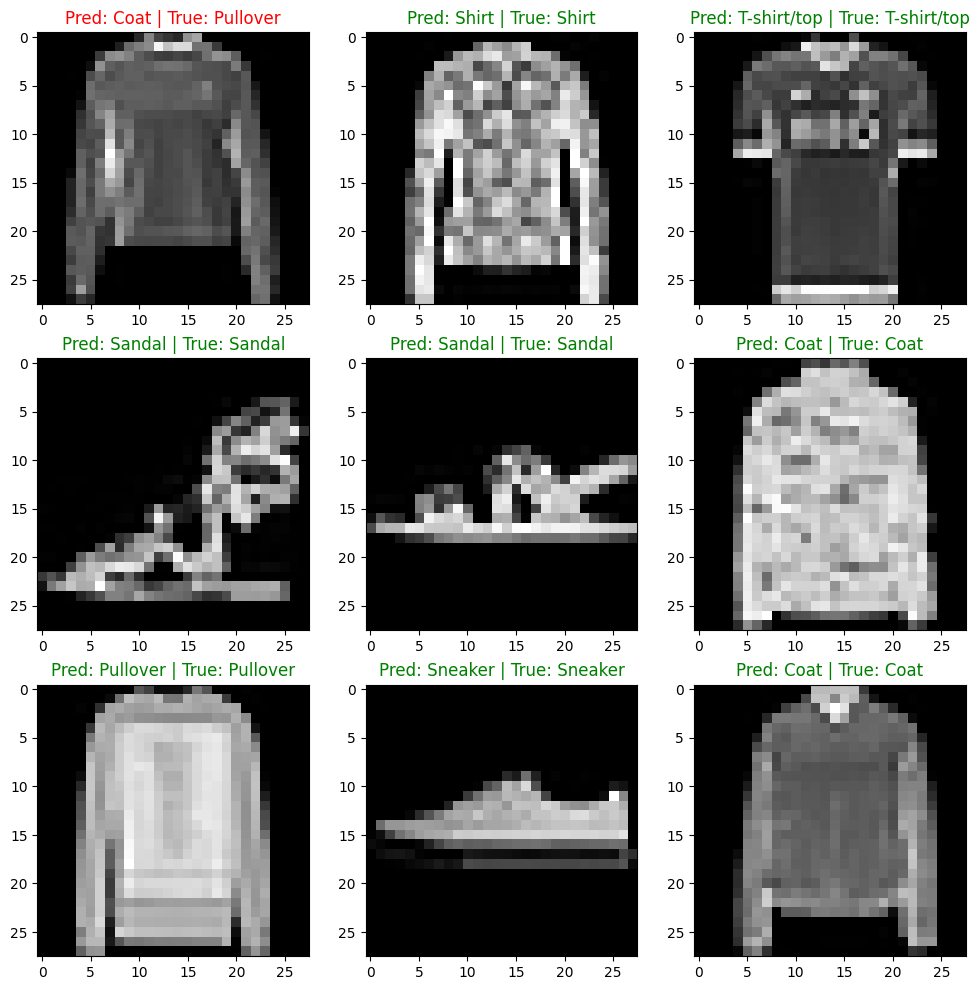

In [88]:
fig = plt.figure(figsize=(12,12))
cols = math.ceil(math.sqrt(9))
rows = math.floor(math.sqrt(9))
for i in range(1,9+1):
    plt.subplot(rows, cols, i)
    plt.imshow(samples[i-1].permute(1,2,0), "gray")
    
    txt = f"Pred: {class_names[predictions[i-1]]} | True: {class_names[labels[i-1]]}"
    if predictions[i-1] == labels[i-1]:
        plt.title(txt, c="g")
    else:
        plt.title(txt, c="r")

In [41]:
math.ceil(math.sqrt(10))

4

In [42]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

In [64]:
torch.save(model_final, "./models/cnn_model.pth")
torch.save(model_final.state_dict(), "./models/cnn_model_state_dict.pth")


In [89]:
model_final.eval()
preds=[]
labels= []
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        preds.append(model_final(X).argmax(dim=1))
        labels.append(y)

In [90]:
predictions = torch.cat(preds)
labels = torch.cat(labels)
predictions

tensor([1, 2, 6,  ..., 9, 3, 7], device='cuda:0')

In [94]:
confmat = ConfusionMatrix(num_classes=len(test_data.classes),task='multiclass')
conf_tensor = confmat(preds = predictions.cpu(), target = labels.cpu())

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

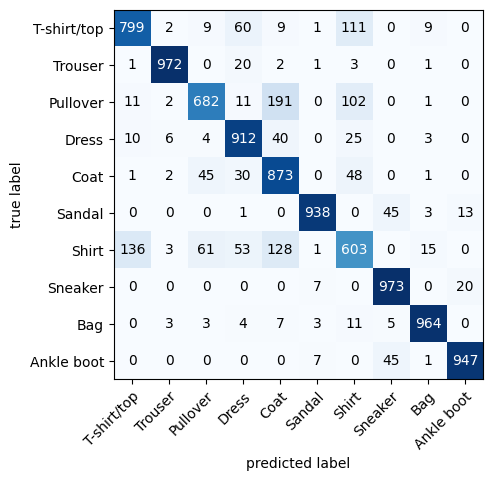

In [96]:
plot_confusion_matrix(conf_tensor.numpy(), class_names=test_data.classes)

In [84]:
criterion(predictions.type(torch.float).cpu(), test_data.targets.type(torch.float))

tensor(531145.8125)

In [98]:
accuracy_score(predictions.cpu(),labels.cpu())

0.8663